# Image Classification
In this notebook Image classification is implemented for dataset of 10 different animals. The images are preprocessed and then a convolutional neural network is trained on all the samples. Convolutional, Dropout, Max Pooling and and fully connected networks are build. At the end there is network prediction on sample images.

In [1]:
#Importing the required libraries

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import layers

# Dataset
There are 10 different directories for different animals in main directory, each of which consists of variable number of images. The images are loaded using openCV and converted to pre-defined size of image and gray-scale therby reducing the total number of channels from 3 to 1. 
The extracted image array and label of that image are stored as tuples in the 'Complete_data' list.

In [2]:
#Dataset is loaded from the directory.

datadir = 'animals'
complete_data = []
img_size = 32
def load_data(datadir):
    class_num = 0
    for directory in os.listdir(datadir):
        path = os.path.join(datadir,directory)
        for image in os.listdir(path):
            img_path = os.path.join(path,image)
            img_arr = cv2.imread(img_path)
            img_arr = cv2.cvtColor(img_arr,cv2.COLOR_BGR2GRAY)
            new_arr = cv2.resize(img_arr,(img_size,img_size))
            new_arr = np.array(new_arr)
            complete_data.append([new_arr,class_num])
            
        class_num += 1

load_data(datadir)

In [3]:
names = []
for name in os.listdir(datadir):
    names.append(name)

for i,name in enumerate(names):
    print(i,name)

0 cane
1 cavallo
2 elefante
3 farfalla
4 gallina
5 gatto
6 mucca
7 pecora
8 ragno
9 scoiattolo


In [4]:
print(len(complete_data))
random.shuffle(complete_data)
x = []
y = []
for features,labels in complete_data:
    x.append(features)
    y.append(labels)
print(x[0].shape)

26179
(32, 32)


# Normalisation
The normalisation function is implemented in the cell below which converts all pixel values between 0 and 1 (inclusive).

In [5]:
def normalise(x):
    min_value = 0
    max_value = 255
    normalised = np.array((x-min_value)/(max_value-min_value))
    return normalised

x_normal = normalise(np.array(x))
print('Pixels of Images without Normalisation')
print(x[0])
print('\n')
print('Pixels after Normalisation')
print(x_normal[0])

Pixels of Images without Normalisation
[[ 67 141 158 ...  19  42 121]
 [ 80 126 146 ...  71 124  31]
 [132 119 127 ...  77  49  35]
 ...
 [203 178 182 ...  96 145 106]
 [166 151 163 ... 139 188 118]
 [176 207 163 ... 140 133  97]]


Pixels after Normalisation
[[0.2627451  0.55294118 0.61960784 ... 0.0745098  0.16470588 0.4745098 ]
 [0.31372549 0.49411765 0.57254902 ... 0.27843137 0.48627451 0.12156863]
 [0.51764706 0.46666667 0.49803922 ... 0.30196078 0.19215686 0.1372549 ]
 ...
 [0.79607843 0.69803922 0.71372549 ... 0.37647059 0.56862745 0.41568627]
 [0.65098039 0.59215686 0.63921569 ... 0.54509804 0.7372549  0.4627451 ]
 [0.69019608 0.81176471 0.63921569 ... 0.54901961 0.52156863 0.38039216]]


In [6]:
def split_data(x,y,train_size=0.8,valid_size=0.06,shuffle=True):
    size = len(x)
    indices = np.arange(size)
    if shuffle==True:
        np.random.shuffle(indices)
        
    train_samples = int(train_size*size)
    valid_samples = int(valid_size*size)
    x_train = x[indices[:train_samples]]
    y_train = y[indices[:train_samples]]
    x_valid = x[indices[train_samples:train_samples+valid_samples]]
    y_valid = y[indices[train_samples:train_samples+valid_samples]]
    x_test = x[indices[train_samples+valid_samples:]]
    y_test = y[indices[train_samples+valid_samples:]]
    
    return x_train,y_train,x_valid,y_valid,x_test,y_test

x_train,y_train,x_valid,y_valid,x_test,y_test = split_data(np.array(x_normal),np.array(y))
print("Number of train samples: ",len(x_train))
print("Number of valid samples: ",len(x_valid))
print("Number of test samples: ",len(x_test))
print('\n')
print(x_train[0])

Number of train samples:  20943
Number of valid samples:  1570
Number of test samples:  3666


[[0.00784314 0.00784314 0.00784314 ... 0.18823529 0.18039216 0.2       ]
 [0.00784314 0.00784314 0.00784314 ... 0.21568627 0.23137255 0.20784314]
 [0.00784314 0.00784314 0.00784314 ... 0.20784314 0.22745098 0.19215686]
 ...
 [0.18431373 0.17254902 0.25882353 ... 0.35294118 0.38431373 0.38039216]
 [0.25490196 0.27058824 0.29019608 ... 0.39215686 0.39215686 0.41176471]
 [0.29019608 0.30588235 0.28235294 ... 0.32941176 0.26666667 0.13333333]]


# Some sample Images

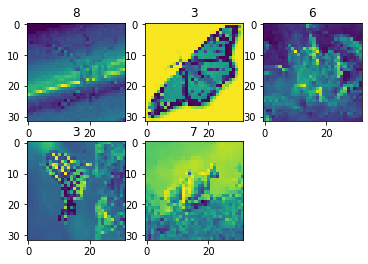

In [7]:
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.imshow(255*x_train[i])
    plt.title(y_train[i])

# Model
The model has three convolutional layers followed by relu activation and Max Pooling. The final feature vector has 64 feature maps of shape(4,4). This layer is flattend and fed into fully-connected network having 2 hidden layers and a output layer. The final output layer has 10 nodes each of which gives probability for the image to be a certain animal corresponding to the names list.

In [8]:
def build_model():
    inputs = layers.Input(shape=(img_size,img_size,1),name="image",dtype=np.float32)
    x = layers.Conv2D(16,(3,3),
                     activation="relu",
                     padding = "same",
                     name = "Conv1")(inputs)
    
    x = layers.MaxPooling2D((2,2),name='Pool1')(x)
    x = layers.Conv2D(32,(3,3),
                     activation="relu",
                     padding = "same",
                     name = "Conv2")(x)
    x = layers.MaxPooling2D((2,2),name='Pool2')(x)
    x = layers.Conv2D(64,(3,3),
                     activation="relu",
                     padding = "same",
                     name = "Conv3")(x)
    x = layers.MaxPooling2D((2,2),name='Pool3')(x)
    x = layers.Flatten()(x)
    x = tf.keras.layers.Dense(256,activation='relu',name='hidden1')(x)
    x = layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(128,activation='relu',name='hidden2')(x)
    x = layers.Dropout(0.1)(x)
    outputs = tf.keras.layers.Dense(10,activation='softmax',name='output')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

model = build_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 32, 32, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 32, 32, 16)        160       
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 16)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 16, 16, 32)        4640      
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 8, 8, 32)          0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 8, 8, 64)          18496     
_________________________________________________________________
Pool3 (MaxPooling2D)         (None, 4, 4, 64)         

# Training the Network

In [9]:
num_epochs = 20
early_stopping_patience = 10

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
batch_size = 20
validation_dataset = (x_valid,y_valid)
model.fit(x_train,y_train,batch_size=batch_size,
          validation_data = validation_dataset,
          epochs=num_epochs,
         callbacks=[early_stopping])

Epoch 1/20
1048/1048 [==============================] - 15s 14ms/step - loss: 1.9963 - accuracy: 0.2908 - val_loss: 1.7179 - val_accuracy: 0.4051
Epoch 2/20
1048/1048 [==============================] - 18s 17ms/step - loss: 1.6108 - accuracy: 0.4436 - val_loss: 1.4864 - val_accuracy: 0.4911
Epoch 3/20
1048/1048 [==============================] - 21s 20ms/step - loss: 1.4422 - accuracy: 0.5022 - val_loss: 1.4831 - val_accuracy: 0.4898
Epoch 4/20
1048/1048 [==============================] - 25s 24ms/step - loss: 1.3256 - accuracy: 0.5427 - val_loss: 1.3700 - val_accuracy: 0.5280
Epoch 5/20
1048/1048 [==============================] - 20s 19ms/step - loss: 1.2257 - accuracy: 0.5747 - val_loss: 1.3805 - val_accuracy: 0.5376
Epoch 6/20
1048/1048 [==============================] - 17s 16ms/step - loss: 1.1302 - accuracy: 0.6107 - val_loss: 1.3185 - val_accuracy: 0.5611
Epoch 7/20
1048/1048 [==============================] - 17s 16ms/step - loss: 1.0369 - accuracy: 0.6417 - val_loss: 1.3623 -

In [10]:
y_pred_hot = model.predict(x_test)
y_pred = np.array(y_pred_hot.argmax(axis=1))
correct = 0
for i in range(len(y_test)):
    if(y_pred[i]==y_test[i]):
        correct += 1
        
test_acc = 100.0*(correct/len(y_test))
print(test_acc)

56.301145662847794


Softmax Output Shape:  (3666, 10)


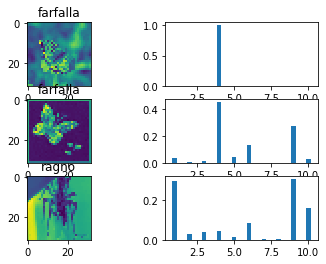

In [12]:
y_pred_hot = np.array(y_pred_hot)
print("Softmax Output Shape: ",y_pred_hot.shape)
plt_x = np.arange(1,11,1)
width = [0.3]
width = np.repeat(width,10)
for i in range(3):
    plt.subplot(3,2,2*(i+1)-1)
    plt.imshow(x_test[i])
    plt.title(names[y_test[i]])
    plt.subplot(3,2,2*(i+1))
    plt.bar(plt_x,y_pred_hot[i],width)
    
plt.show()